## Cleanup Process

In [95]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import RFE

import matplotlib.pyplot as plt
import seaborn as sns

from copy import deepcopy
from tqdm import tqdm

### Dataframe Initialization and Preliminary Analysis

The 3D dataset will combine data from the pylidc and radiomics feature sets, along with deep feature extraction conducted using a MONAI neural network.

In [96]:
df1 = pd.read_csv('cnn_features.csv')
df2 = pd.read_csv('meta_info_3d.csv')

# Find common columns
common_columns = [col for col in df1.columns if col in df2.columns]

# Keep only one if they are identical in both DataFrames
for col in common_columns:
    if df1[col].equals(df2[col]): df2 = df2.drop(columns=[col]) 
 
# Merge dataframes and export to new dataset
df = pd.concat([df1, df2], axis=1)
df.to_csv('.\\clean\\merged_3d.csv', index=False)

In [97]:
# Number of columns for each data type
print("\nNumber of Columns for Each Data Type:")
print(df.dtypes.value_counts())

print('-----------------------------------')

# Only showing columns with missing values
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]  # Filter to show only columns with missing values
print("\nColumns with Missing Values:")
print(missing_values)

print('-----------------------------------')

# Number of unique values per column
print("\nNumber of Unique Values per Column:")
print(df.nunique())

print('-----------------------------------')

df.head()


Number of Columns for Each Data Type:
float64    619
object       2
int64        2
Name: count, dtype: int64
-----------------------------------

Columns with Missing Values:
Series([], dtype: int64)
-----------------------------------

Number of Unique Values per Column:
patient_id                    871
nodule_idx                     23
malignancy                      9
is_cancer                       3
resnet3d_feature_0           2625
                             ... 
original_ngtdm_Busyness         1
original_ngtdm_Coarseness       1
original_ngtdm_Complexity       1
original_ngtdm_Contrast         1
original_ngtdm_Strength         1
Length: 623, dtype: int64
-----------------------------------


,patient_id,nodule_idx,malignancy,is_cancer,resnet3d_feature_0,resnet3d_feature_1,resnet3d_feature_2,resnet3d_feature_3,resnet3d_feature_4,resnet3d_feature_5,...,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
0,LIDC-IDRI-0001,0,5.0,True,1.999915,0.654481,0.010412,0.677332,4.946937,2.852740,...,3.217328e-09,3.217328e-09,-3.203427e-16,0.000057,0.0,0.0,1000000.0,0.0,0.0,0.0
1,LIDC-IDRI-0002,0,4.5,True,1.722624,0.566323,0.012774,0.905643,4.922500,2.808539,...,1.771510e-09,1.771510e-09,-3.203427e-16,0.000042,0.0,0.0,1000000.0,0.0,0.0,0.0
2,LIDC-IDRI-0003,0,2.0,False,1.925799,0.541719,0.030587,0.713345,4.636407,2.736021,...,2.090752e-09,2.090752e-09,-3.203427e-16,0.000046,0.0,0.0,1000000.0,0.0,0.0,0.0
3,LIDC-IDRI-0003,1,4.5,True,1.978363,0.523451,0.000000,0.815097,4.655786,2.635350,...,3.215139e-09,3.215139e-09,-3.203427e-16,0.000057,0.0,0.0,1000000.0,0.0,0.0,0.0
4,LIDC-IDRI-0003,2,3.5,Ambiguous,2.079020,0.590542,0.030947,0.855208,4.822085,2.612184,...,4.686175e-09,4.686175e-09,-3.203427e-16,0.000068,0.0,0.0,1000000.0,0.0,0.0,0.0


A preliminary examination of our dataframe indicates that it contains a significant number of columns, primarily consisting of floating-point values. Currently, there are no missing values; however, we need to conduct a more in-depth analysis to explore the distribution of data, identify potential outliers, examine correlations between variables, and assess overall data quality.

This Jupyter notebook allows you to review all the modifications made to the dataset.

We will now apply various data analysis techniques to assess the relevance and utility of these columns.

### Simple Considerations

First, we will identify and remove obviously irrelevant columns:

 - `nodule_idx` does not hold significant relevance for our analysis.
 - Since `is_cancer` captures the essential aspect of `malignancy` and will serve as our target variable, we can exclude the `malignancy` column.

Additionally, we determined that adding a new column to represent the total number of nodules per patient could be informative. This new feature is important as it might indicate whether having multiple nodules increases the likelihood of some being cancerous, or perhaps raises the overall risk.

In [98]:
df.drop("nodule_idx", axis=1, inplace=True)
df.drop("malignancy", axis=1, inplace=True)


# Creates a new column that counts the occurrences of each patient_id
df['patient_nodule_count'] = df.groupby('patient_id').cumcount() + 1
insert_position = df.columns.get_loc('patient_id') +1
# Places new column in front of patient_id
df.insert(insert_position, 'patient_nodule_count', df.pop('patient_nodule_count'))

df.drop("patient_id", axis=1, inplace=True)


df.head()

,patient_nodule_count,is_cancer,resnet3d_feature_0,resnet3d_feature_1,resnet3d_feature_2,resnet3d_feature_3,resnet3d_feature_4,resnet3d_feature_5,resnet3d_feature_6,resnet3d_feature_7,...,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
0,1,True,1.999915,0.654481,0.010412,0.677332,4.946937,2.852740,1.334359,4.105425,...,3.217328e-09,3.217328e-09,-3.203427e-16,0.000057,0.0,0.0,1000000.0,0.0,0.0,0.0
1,1,True,1.722624,0.566323,0.012774,0.905643,4.922500,2.808539,1.638239,4.224512,...,1.771510e-09,1.771510e-09,-3.203427e-16,0.000042,0.0,0.0,1000000.0,0.0,0.0,0.0
2,1,False,1.925799,0.541719,0.030587,0.713345,4.636407,2.736021,1.203993,4.424734,...,2.090752e-09,2.090752e-09,-3.203427e-16,0.000046,0.0,0.0,1000000.0,0.0,0.0,0.0
3,2,True,1.978363,0.523451,0.000000,0.815097,4.655786,2.635350,1.258861,3.846047,...,3.215139e-09,3.215139e-09,-3.203427e-16,0.000057,0.0,0.0,1000000.0,0.0,0.0,0.0
4,3,Ambiguous,2.079020,0.590542,0.030947,0.855208,4.822085,2.612184,1.310962,4.156609,...,4.686175e-09,4.686175e-09,-3.203427e-16,0.000068,0.0,0.0,1000000.0,0.0,0.0,0.0


Next, we will eliminate any columns that contain only a single unique value or duplicate the exact values found in another column.

In [99]:
df = df.loc[:, df.nunique() > 1]
df = df.loc[:,~df.T.duplicated()] # treats columns as lines in order to find duplicates
df.head()

,patient_nodule_count,is_cancer,resnet3d_feature_0,resnet3d_feature_1,resnet3d_feature_2,resnet3d_feature_3,resnet3d_feature_4,resnet3d_feature_5,resnet3d_feature_6,resnet3d_feature_7,...,original_glrlm_RunVariance,original_glrlm_ShortRunEmphasis,original_glszm_GrayLevelNonUniformity,original_glszm_LargeAreaEmphasis,original_glszm_SizeZoneNonUniformity,original_glszm_SizeZoneNonUniformityNormalized,original_glszm_SmallAreaEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance
0,1,True,1.999915,0.654481,0.010412,0.677332,4.946937,2.852740,1.334359,4.105425,...,34.965274,0.167107,1.0,310816900.0,1.0,1.0,3.217328e-09,-3.203427e-16,0.000057,0.0
1,1,True,1.722624,0.566323,0.012774,0.905643,4.922500,2.808539,1.638239,4.224512,...,50.731408,0.117219,1.0,564490081.0,1.0,1.0,1.771510e-09,-3.203427e-16,0.000042,0.0
2,1,False,1.925799,0.541719,0.030587,0.713345,4.636407,2.736021,1.203993,4.424734,...,47.648678,0.153129,1.0,478296900.0,1.0,1.0,2.090752e-09,-3.203427e-16,0.000046,0.0
3,2,True,1.978363,0.523451,0.000000,0.815097,4.655786,2.635350,1.258861,3.846047,...,36.955817,0.175483,1.0,311028496.0,1.0,1.0,3.215139e-09,-3.203427e-16,0.000057,0.0
4,3,Ambiguous,2.079020,0.590542,0.030947,0.855208,4.822085,2.612184,1.310962,4.156609,...,30.325847,0.153906,1.0,213393664.0,1.0,1.0,4.686175e-09,-3.203427e-16,0.000068,0.0


### Outliers


In [100]:
'''def remove_outliers(df):
    # Initialize a mask for filtering out outliers
    mask = pd.Series([True] * len(df))  # Start with all True (no outliers)

    for col in df.select_dtypes(include=['float64', 'int64']).columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Update the mask for the outlier conditions
        mask &= (df[col] >= lower_bound) & (df[col] <= upper_bound)

    # Return a new DataFrame without outliers
    return df[mask]

# Remove outliers from the original DataFrame
df_no_outliers = remove_outliers(df)

# Check the shape of the DataFrame before and after removing outliers
print(f"Original DataFrame shape: {df.shape}")
print(f"DataFrame shape after removing outliers: {df_no_outliers.shape}")'''

'def remove_outliers(df):\n    # Initialize a mask for filtering out outliers\n    mask = pd.Series([True] * len(df))  # Start with all True (no outliers)\n\n    for col in df.select_dtypes(include=[\'float64\', \'int64\']).columns:\n        Q1 = df[col].quantile(0.25)\n        Q3 = df[col].quantile(0.75)\n        IQR = Q3 - Q1\n        lower_bound = Q1 - 1.5 * IQR\n        upper_bound = Q3 + 1.5 * IQR\n        \n        # Update the mask for the outlier conditions\n        mask &= (df[col] >= lower_bound) & (df[col] <= upper_bound)\n\n    # Return a new DataFrame without outliers\n    return df[mask]\n\n# Remove outliers from the original DataFrame\ndf_no_outliers = remove_outliers(df)\n\n# Check the shape of the DataFrame before and after removing outliers\nprint(f"Original DataFrame shape: {df.shape}")\nprint(f"DataFrame shape after removing outliers: {df_no_outliers.shape}")'

### Unbalanced Classes


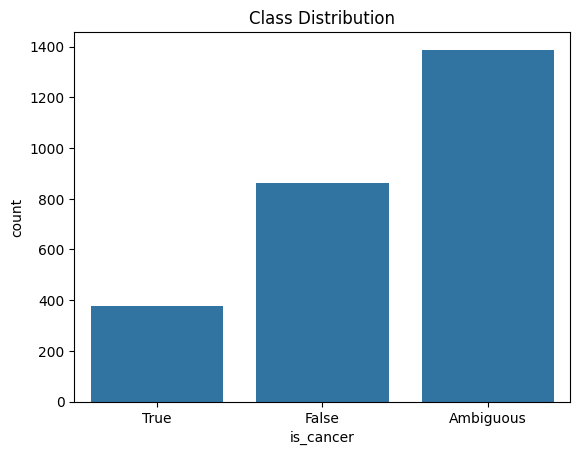

Class Distribution:
is_cancer
Ambiguous    0.528561
False        0.328637
True         0.142803
Name: proportion, dtype: float64


In [101]:
# Check for class balance
sns.countplot(x='is_cancer', data=df)
plt.title('Class Distribution')
plt.show()

# Check the balance programmatically
class_distribution = df['is_cancer'].value_counts(normalize=True)
print("Class Distribution:")
print(class_distribution)

### 0-1 Normalization

In [102]:
# Normalizing numeric columns
scaler = MinMaxScaler()
numeric_cols = df.select_dtypes(include=['float64']).columns

# Normalize the data
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# Check the first few rows of the normalized DataFrame
df.head()

,patient_nodule_count,is_cancer,resnet3d_feature_0,resnet3d_feature_1,resnet3d_feature_2,resnet3d_feature_3,resnet3d_feature_4,resnet3d_feature_5,resnet3d_feature_6,resnet3d_feature_7,...,original_glrlm_RunVariance,original_glrlm_ShortRunEmphasis,original_glszm_GrayLevelNonUniformity,original_glszm_LargeAreaEmphasis,original_glszm_SizeZoneNonUniformity,original_glszm_SizeZoneNonUniformityNormalized,original_glszm_SmallAreaEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance
0,1,True,0.425591,0.747230,0.033385,0.362830,0.711941,0.684241,0.326003,0.326814,...,0.446868,0.496851,0.0,0.374053,0.0,1.0,4.015670e-09,0.0,0.030123,0.0
1,1,True,0.204168,0.553091,0.040961,0.581978,0.687973,0.615764,0.562637,0.410630,...,0.667769,0.253756,0.0,0.681792,0.0,1.0,1.124034e-09,0.0,0.010037,0.0
2,1,False,0.366408,0.498907,0.098079,0.397398,0.407383,0.503418,0.224485,0.551552,...,0.624576,0.428741,0.0,0.577229,0.0,1.0,1.762517e-09,0.0,0.015027,0.0
3,2,True,0.408381,0.458678,0.000000,0.495066,0.426389,0.347457,0.267212,0.144256,...,0.474758,0.537671,0.0,0.374310,0.0,1.0,4.011292e-09,0.0,0.030097,0.0
4,3,Ambiguous,0.488758,0.606425,0.099234,0.533566,0.589490,0.311566,0.307783,0.362838,...,0.381864,0.432529,0.0,0.255866,0.0,1.0,6.953363e-09,0.0,0.046231,0.0


### Correlation


To assess the degree of correlation between the columns and the target variable, and gain better insight about the feature's importance, we decided to create a new DataFrame. We chose the interval of 0.55 and -0.55 as it effectively captures some correlation, both positive and negative. That interval can be changed below.

However, to facilitate this analysis, we must first convert the `patient_id` and `is_cancer` columns into tangible numerical formats. This conversion is essential because correlation calculations require numeric inputs to assess the relationship between variables accurately. 

In [103]:
# Map is_cancer values to numeric representations
df['is_cancer'] = df['is_cancer'].map({'False': 0, 'Ambiguous': 1, 'True': 2})

df.head()

,patient_nodule_count,is_cancer,resnet3d_feature_0,resnet3d_feature_1,resnet3d_feature_2,resnet3d_feature_3,resnet3d_feature_4,resnet3d_feature_5,resnet3d_feature_6,resnet3d_feature_7,...,original_glrlm_RunVariance,original_glrlm_ShortRunEmphasis,original_glszm_GrayLevelNonUniformity,original_glszm_LargeAreaEmphasis,original_glszm_SizeZoneNonUniformity,original_glszm_SizeZoneNonUniformityNormalized,original_glszm_SmallAreaEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance
0,1,2,0.425591,0.747230,0.033385,0.362830,0.711941,0.684241,0.326003,0.326814,...,0.446868,0.496851,0.0,0.374053,0.0,1.0,4.015670e-09,0.0,0.030123,0.0
1,1,2,0.204168,0.553091,0.040961,0.581978,0.687973,0.615764,0.562637,0.410630,...,0.667769,0.253756,0.0,0.681792,0.0,1.0,1.124034e-09,0.0,0.010037,0.0
2,1,0,0.366408,0.498907,0.098079,0.397398,0.407383,0.503418,0.224485,0.551552,...,0.624576,0.428741,0.0,0.577229,0.0,1.0,1.762517e-09,0.0,0.015027,0.0
3,2,2,0.408381,0.458678,0.000000,0.495066,0.426389,0.347457,0.267212,0.144256,...,0.474758,0.537671,0.0,0.374310,0.0,1.0,4.011292e-09,0.0,0.030097,0.0
4,3,1,0.488758,0.606425,0.099234,0.533566,0.589490,0.311566,0.307783,0.362838,...,0.381864,0.432529,0.0,0.255866,0.0,1.0,6.953363e-09,0.0,0.046231,0.0


We are now able to compute the correlation matrix effectively and gain insights into the relationships within the dataset:

In [105]:
df2 = deepcopy(df)
correlation_matrix = df2.corr()
is_cancer_corr = correlation_matrix['is_cancer'] 

# Identifying strong correlations with 'is_cancer'
strong_corr_with_is_cancer = is_cancer_corr[(is_cancer_corr > 0.35) | (is_cancer_corr < -0.35)] # can be changed later

# Dropping the 'is_cancer' entry from the results
strong_corr_with_is_cancer = strong_corr_with_is_cancer.drop('is_cancer')
print('There are', strong_corr_with_is_cancer.shape[0], 'columns with a correlation in that range.')
strong_corr_with_is_cancer.head(20)

There are 7 columns with a correlation in that range.


original_shape_SurfaceArea                         0.390094
original_firstorder_10Percentile                   0.481469
original_firstorder_InterquartileRange            -0.392992
original_firstorder_MeanAbsoluteDeviation         -0.373613
original_firstorder_RobustMeanAbsoluteDeviation   -0.389013
original_firstorder_Skewness                      -0.449036
original_glrlm_GrayLevelNonUniformity              0.389892
Name: is_cancer, dtype: float64

We only want to retain the `patient_nodule_count`, and `is_cancer` columns, along with those that have demonstrated strong correlation values.

In [68]:
# List of columns to keep
columns_to_keep = ['patient_nodule_count', 'is_cancer'] + strong_corr_with_is_cancer.index.tolist()

# New DataFrame with the selected columns
filtered_df = df[columns_to_keep]

filtered_df.head()

,patient_nodule_count,is_cancer,original_shape_SurfaceArea,original_firstorder_10Percentile,original_firstorder_InterquartileRange,original_firstorder_MeanAbsoluteDeviation,original_firstorder_RobustMeanAbsoluteDeviation,original_firstorder_Skewness,original_glrlm_GrayLevelNonUniformity
0,1,2,8872.590061,0.838241,0.000000,0.087923,0.002344,-3.559762,2997.846154
1,1,2,8963.450033,0.605107,0.000000,0.014997,0.000000,-7.946331,3033.230769
2,1,0,8794.281313,0.715036,0.000000,0.054564,0.000000,-4.143610,2983.846154
3,2,2,8220.231161,0.791201,0.000000,0.102551,0.005736,-3.388875,2782.384615
4,3,1,7613.041105,0.325999,0.445045,0.321047,0.220659,-1.252478,2582.692308


In [69]:
#########################################
#possivelmente comentamos algo como, since the correlations are that well defined, to choose another way of selecting cols, we will use:
#########################################

### 2. Recursive Feature Elimination (RFE)

 **Recursive Feature Elimination** (RFE) is a feature selection method that works by **recursively eliminating less important features** to help improve model performance and reduce dimensionality. 
    
It involves training a machine learning model, in this case, a **Random Forest Classifier** and using its performance to evaluate the feature's importance. It starts by training the model on the full set of features.
     
After training, the model assigns importance scores to each feature, based on how much they contribute to reduce the impurity or error when used in splits.
     

In [70]:
X = df.drop(columns=['is_cancer'])  # All columns except the target
y = df['is_cancer']  # Target variable

# Train-test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate RF model
model = RandomForestClassifier(random_state=42)

# Apply RFE to select the top N features
rfe = RFE(estimator=model, n_features_to_select=50)  # Select top N features
X_train_rfe = rfe.fit_transform(X_train, y_train)  # Fit RFE and transform training data
X_test_rfe = rfe.transform(X_test)  # Transform test data using the selected features

# Fit Random Forest model on the selected features
model.fit(X_train_rfe, y_train)

# Predict on the test set
y_pred = model.predict(X_test_rfe)

'''
# Print the selected columns
selected_columns = X.columns[rfe.support_]
print("Selected Features:", selected_columns)
'''

KeyboardInterrupt: 

In [ ]:
selected_columns = X.columns[rfe.support_]
df_rfe50 = df[['is_cancer'] + list(selected_columns)]

df_rfe50.to_csv('clean_rfe50.csv', index=False)

Then we can **evaluate the performance of the dataset after the RFE**, when the random forest is applied.

In [42]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score


# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report (includes Precision, Recall, and F1 Score)
class_report = classification_report(y_test, y_pred, target_names=['False', 'Ambiguous', 'True'])
print("\nClassification Report:")
print(class_report)

# Macro-Averaged F1 Score
f1_macro = f1_score(y_test, y_pred, average='macro')
print(f"Macro-Averaged F1 Score: {f1_macro:.4f}")

# Weighted-Averaged F1 Score
f1_weighted = f1_score(y_test, y_pred, average='weighted')
print(f"Weighted-Averaged F1 Score: {f1_weighted:.4f}")


# ROC-AUC score (One-vs-Rest for multi-class classification)
# We need the probability estimates for calculating ROC-AUC.
y_pred_proba = model.predict_proba(X_test_rfe)
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class="ovr")
print(f"ROC-AUC Score (One-vs-Rest): {roc_auc:.4f}")


Confusion Matrix:
[[10  5  0]
 [ 1 11  2]
 [ 0  0  4]]

Classification Report:
              precision    recall  f1-score   support

       False       0.91      0.67      0.77        15
   Ambiguous       0.69      0.79      0.73        14
        True       0.67      1.00      0.80         4

    accuracy                           0.76        33
   macro avg       0.75      0.82      0.77        33
weighted avg       0.79      0.76      0.76        33

Macro-Averaged F1 Score: 0.7675
Weighted-Averaged F1 Score: 0.7577
ROC-AUC Score (One-vs-Rest): 0.8993


For reference, the confusion matrix is formatted as shown below.

| Actual \ Predicted | False (0) | Ambiguous (1) | True (2) |
|--------------------|-----------|---------------|----------|
| **False (0)**       | .       | .             | .       |
| **Ambiguous (1)**   | .         | .            | .        |
| **True (2)**        |      .| .            | .        |




Notice that, to reduce the number of features, we could also use **Principal Component Analysis** (PCA). However, although both PCA and RFE aim to reduce the feature set, they work in fundamentally different ways:

- **RFE** (Recursive Feature Elimination) reduces the number of features by **recursively selecting the most important ones** based on their contribution to the model's performance.
- **PCA** (Principal Component Analysis) reduces dimensionality by **creating new features**, which are **linear combinations of the original ones**, and selects the components that capture the most variance.

In this case, since it makes sense to select features based on their relevance to the end result (target variable), we have opted for the first approach, **RFE**. Nevertheless, **part of the** implementation of PCA is also provided below for reference.

```py

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# StandardScaler() is important for PCA. 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=0.95)  # Retains 95% of variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Print the number of components selected by PCA
print(f"Number of original components: {X_train.shape[1]}")
print(f"Number of PCA components selected: {X_train_pca.shape[1]}")

```

## Modeling

In [ ]:
############# a partir daqui e preciso ver se se faz aqui, se se importa para o report somehow, etc... ############

In [35]:
'''
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
'''

'\nfrom sklearn.preprocessing import LabelEncoder\n\nlabel_encoder = LabelEncoder()\ny_train = label_encoder.fit_transform(y_train)\ny_test = label_encoder.transform(y_test)\n'

In [36]:
'''
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

# Initialize the XGBoost model with regularization
xgb_model = XGBClassifier(random_state=42, reg_alpha=0.01, reg_lambda=0.01)

# Step 8: Define hyperparameter search space for tuning
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Step 9: Perform grid search for hyperparameter tuning
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='f1_macro', n_jobs=-1, verbose=2)
grid_search.fit(X_train_pca, y_train) ####################################################################################### fiz isto para tentar ver se e pertinente dar tuning na NN, isto serviu de exemplo

# Use the best estimator found by GridSearchCV, not working as I want but might not be necessary
best_xgb_model = grid_search.best_estimator_

# check performance
y_pred = best_xgb_model.predict(X_test_pca)
accuracy = accuracy_score(y_test, y_pred)

# Train and test using original (scaled) data without PCA to compare
grid_search.fit(X_train_scaled, y_train)

print(f"XGBoost model accuracy with PCA: {accuracy}")

import matplotlib.pyplot as plt
from xgboost import plot_importance

# Assuming grid_search.best_estimator_ is your trained XGBoost model
xgb_model = grid_search.best_estimator_

# Plot feature importance
plt.figure(figsize=(10, 8))
plot_importance(xgb_model, max_num_features=10)  # Adjust max_num_features to show more or fewer
plt.title('Feature Importance')

# Save the plot as a file (PNG in this example)
plt.savefig('xgboost_feature_importance.png', dpi=300, bbox_inches='tight')

plt.close()


SyntaxError: incomplete input (1043158175.py, line 1)

In [ ]:
import pandas as pd
import numpy as np

# Assuming `pca` is your PCA object and `X_train` is your original feature set
pca_components = pca.components_

# Create a DataFrame for better visualization
feature_names = X_train.columns
pca_df = pd.DataFrame(data=pca_components, columns=feature_names)

# Display the contributions of each feature to the PCA components
print(pca_df)
